# Attempt to Model Velocity Dependence _with DNNs_
Retry the problem form the previous notebook

In [1]:
%matplotlib inline
import os
import sys
# Add the directory containing your module to the Python path
sys.path.append(os.path.abspath('/scratch/users/pdanie20/PD-stopping-power-ml'))

from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.keras import build_fn as build_dense
from glob import glob
from tqdm import tqdm_notebook as tqdm

from keras.layers import Dense, Activation, Input
from keras.layers import Concatenate, Multiply, Add
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle as pkl
import numpy as np
import pandas as pd


2024-06-09 17:37:09.696605: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 17:37:09.697380: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 17:37:10.931757: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 17:37:11.843909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 17:37:15.945070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Load in Data
Read in the random trajectories

In [3]:
data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/PD-stopping-power-ml/multiple-velocities', 'random_traj.pkl'))

In [5]:
channel_data = pd.read_pickle(os.path.join('/scratch/users/pdanie20/PD-stopping-power-ml/multiple-velocities', 'channel_traj.pkl')).query('average_range')

In [6]:
with open('featurizer.pkl', 'rb') as fp:
    featurizer = pkl.load(fp)

Get the features

In [7]:
X_cols = featurizer.feature_labels()

In [8]:
X_cols_novel = list(X_cols)
X_cols_novel.remove("velocity_mag")

In [9]:
X_cols_vel = ["velocity_mag"]

In [10]:
y_col = 'force'

## Create Functions for Building Models
Create functions for building a Keras model

In [11]:
input_shape = (len(X_cols_novel),)
v_input_shape = (len(X_cols_vel),)
layers = (input_shape[0],32,24,8,4,3)
v_layers = (v_input_shape[0],3,3)
m_layers = (layers[-1],3)
activation = 'elu'

In [13]:
#optimizer_options = {
 #   'loss': 'mean_absolute_error', 
  #  'optimizer': Adam(lr=0.0005),
   # 'metrics': ['mean_absolute_error']
#}

optimizer_options = {
    'loss': 'mean_absolute_error', 
    'optimizer': Adam(learning_rate=0.0005),
    'metrics': ['mean_absolute_error']
}

In [14]:
callbacks = [EarlyStopping(monitor='mean_absolute_error', patience=100, verbose=0, mode='auto'),
             ReduceLROnPlateau('mean_absolute_error')]

### Standard Dense Model
Just treat all layers equally

In [15]:
model = build_dense(len(X_cols), layers, activation=activation, use_linear_block=False,
                   optimizer_options=optimizer_options)

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,015 (7.87 KB)

 Trainable params: 2,015 (7.87 KB)

 Non-trainable params: 0 (0.00 B)

### Model with Velocity Separate
Train two inputs: One based on the features, another based on velocity

In [17]:
def build_velocity_merge_model(layers, v_layers, m_layers, input_shape, v_input_shape, 
                               activation, merge_type=Multiply, optimizer='adam', loss='mean_absolute_error', summary=False):
    """Create a model where the velocity input is treated separately, and later merged in with the main model
    
    Args:
        layers ([int]) - layers for the main inputs
        v_layers ([int]) - layers for the velocity input
        m_layers ([int]]) - layers after the two input networks are merged
        input_shape ([int]) - Shape of the main inputs
        v_input_shape ([int]) - Shape of the velocity inputs
        activation (str) - Type of the activation layer
        merge_type (Layer) - Method used to combine the layers
        optimizer (str) - Optimization method
        loss (str) - Loss metric
        summary (bool) - Whether to print summary
    Returns:
        (Model): Keras model
    """
    
    # Make the network for the main features
    main_input = Input(shape=input_shape)
    l = Dense(layers[0], activation=activation)(main_input)
    for layer in layers[1:]:
        l = (Dense(layer, activation=activation))(l)
        
    # Make the network for both
    v_input = Input(shape=v_input_shape)
    r = Dense(v_layers[0], activation=activation)(v_input)
    for v_layer in v_layers[1:]:
        r = (Dense(v_layer, activation=activation))(r)
        
    # Multiple them together
    m = merge_type()([l, r])
    
    # Make the post-merge network
    for m_layer in m_layers:
        m = (Dense(m_layer, activation=activation))(m)
        
    output = Dense(1, activation='linear')(m)
    
    model = Model(inputs=[main_input, v_input], 
                         outputs=[output])
    
    model.compile(loss=loss, optimizer=optimizer, metrics=[loss])
    if summary:
        model.summary()
    return model

Build an initial model

In [18]:
merge_model = build_velocity_merge_model(layers, v_layers, m_layers, input_shape, v_input_shape, activation)

In [19]:
merge_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 18)        │        342 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │        608 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 24)        │        792 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8)         │        200 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │          2 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 4)         │         36 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 3)         │          6 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 3)         │         15 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 3)         │         12 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 3)         │          0 │ dense_11[0][0],   │
│                     │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 3)         │         12 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 3)         │         12 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │          4 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,041 (7.97 KB)

 Trainable params: 2,041 (7.97 KB)

 Non-trainable params: 0 (0.00 B)

## Test on the Whole Dataset
Fit the model on the whole dataset

In [20]:
def fit_on_whole_dataset(model, data, callbacks=[], epochs=1, split_v=False):
    """Train a model on the whole dataset
    
    Args:
        model (Model): Model to be trained 
        callbacks ([List]): List of callbacks used during training
        epochs (int): Maximum number of epochs for training
    Returns:
        history - history from the fit
    """

    # Train the model
    if split_v:
        return model.fit([data[X_cols_novel], data[X_cols_vel]], data[y_col], epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        return model.fit(data[X_cols], data[y_col], epochs=epochs, callbacks=callbacks, verbose=0)

Fit the whole model

In [21]:
%%time
dense_history = fit_on_whole_dataset(model, data, callbacks, 1000, False)

CPU times: user 18min 36s, sys: 25.7 s, total: 19min 2s
Wall time: 34min 53s


In [26]:
%%time
merge_history = fit_on_whole_dataset(merge_model, data, callbacks, 1000, True)

CPU times: user 2min 55s, sys: 3.02 s, total: 2min 58s
Wall time: 4min 14s


Plot results

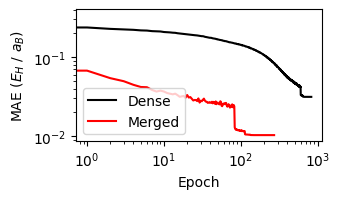

In [23]:
fig, ax = plt.subplots()

ax.loglog(dense_history.epoch, dense_history.history['mean_absolute_error'], 'k', label='Dense')
ax.loglog(merge_history.epoch, merge_history.history['mean_absolute_error'], 'r', label='Merged')

ax.set_ylabel('MAE ($E_H$ / $a_B$)')
ax.set_xlabel('Epoch')

ax.legend()

fig.set_size_inches(3.5, 2.1)
fig.tight_layout()

## Evaluate Model Performance
Get the performance of the model on the whole dataset

In [24]:
def plot_performance(model, split_v):
    """Evaluate and plot the performance of the model on multiple velocities
    
    Args:
        model (keras.Model): Model to be trained
        data (pd.Dataframe): Training set
    """

    # Evaluate on the whole dataset
    if split_v:
        data['force_fit'] = model.predict([data[X_cols_novel], data[X_cols_vel]])
    else:
        data['force_fit'] = model.predict(data[X_cols])

    # Plot results
    fig, axs = plt.subplots(1, 3)

    velocity = []
    stopping_pred = []
    stopping_actual = []
    for gid, group in data.groupby('directory'):
        # Store the velocity
        velocity.append(group['velocity_mag'].mean())
        
        # Plot the performance on a segment of the dataset
        label = 'v={:.1f}'.format(group['velocity_mag'].mean())
        
        for a in axs[:2]:
            my_line, = a.plot(group['displacement'], group['force'], linestyle='--',
                                  label=label)

            a.plot(group['displacement'], group['force_fit'].tolist(), color=my_line.get_color(), lw=3, alpha=0.5)
            
            a.set_xlabel('Displacement (a.u.)')
            a.set_ylabel('Force ($E_H / a_B$)')
        
        # Select a certain subset
        axs[0].set_xlim(40, 60)
        #ax[0].set_ylim(-0.3, 0.7)
        axs[0].set_yscale('symlog')
        #ax[0].legend(ncol=2)
        
        # Select a certain subset
        axs[1].set_xlim(52, 65)
        axs[1].set_ylim(-0.5, 0.9)
        #ax[1].legend(ncol=2)
        
        # Store the stopping pwoers
        stopping_pred.append(group['force_fit'].mean())
        stopping_actual.append(group['force'].mean())
        
    # Plot the stopping power
    axs[2].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
    axs[2].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')
    
    axs[2].set_ylabel('Stopping Power ($E_H / a_B$)')
    axs[2].set_xlabel('Velocity (au.)')
    axs[2].set_ylim(0, max(axs[2].get_ylim()))
    axs[2].set_xlim(0, 4.2)
    axs[2].legend()
    
    fig.set_size_inches(8, 2.5)
    fig.tight_layout()
    
    # Print the MAPE
    stopping_mape = np.abs(np.subtract(stopping_actual, stopping_pred) / stopping_actual).mean()
    print(f'Mean percent error: {stopping_mape * 100:.2f}%')
    
    return fig, ax, data

Plot the dense model

1449/1449 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step
Mean percent error: 14.60%


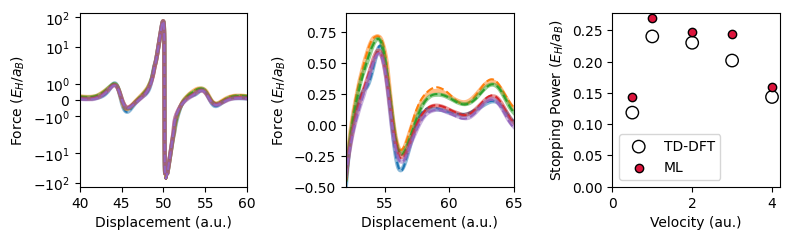

In [27]:
fig, ax, data = plot_performance(model, False)
data.to_csv(os.path.join('/scratch/users/pdanie20/PD-stopping-power-ml/multiple-velocities', 'fit-random-predict-random.csv'), index=False)

1449/1449 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Mean percent error: 1.05%


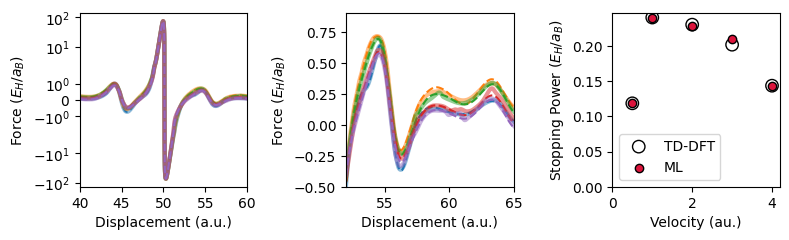

In [28]:
plot_performance(merge_model, True);

*Finding*: The model does interpolate between different velocities decently. The merged model has better agreement on the stopping powers, but does have some unrealistic wobbles. We might just need to apply some regularization to the model

## Prediction on the Channel Trajectory
Do we capture the behavior that the difference between "channel" and "random" increases with velocity?

In [29]:
%%time
channel_data['force_fit'] = model.predict(channel_data[X_cols])

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
CPU times: user 182 ms, sys: 1.99 ms, total: 184 ms
Wall time: 346 ms


Plot change with velocity

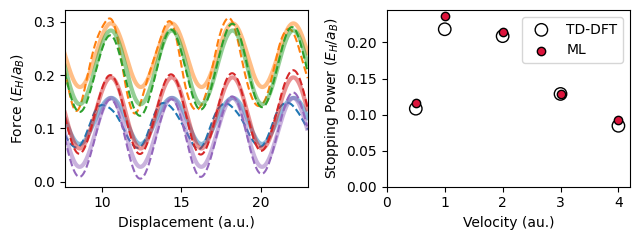

In [30]:
# Plot results
fig, axs = plt.subplots(1, 2)

velocity = []
stopping_pred = []
stopping_actual = []
for gid, group in channel_data.groupby('directory'):
    # Store the velocity
    velocity.append(group['velocity_mag'].mean())

    # Plot the performance on a segment of the dataset
    label = 'v={:.1f}'.format(group['velocity_mag'].mean())

    for a in axs[:1]:
        my_line, = a.plot(group['displacement'], group['force'], linestyle='--',
                              label=label)

        a.plot(group['displacement'], group['force_fit'].tolist(), color=my_line.get_color(), lw=3, alpha=0.5)

        a.set_xlabel('Displacement (a.u.)')
        a.set_ylabel('Force ($E_H / a_B$)')

    # Store the stopping pwoers
    stopping_pred.append(group['force_fit'].mean())
    stopping_actual.append(group['force'].mean())
    
# Clean up the axis ranges
axs[0].set_xlim(channel_data['displacement'].min(), channel_data['displacement'].max())


# Plot the stopping power
axs[1].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
axs[1].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')

axs[1].set_ylabel('Stopping Power ($E_H / a_B$)')
axs[1].set_xlabel('Velocity (au.)')
axs[1].set_ylim(0, max(axs[1].get_ylim()))
axs[1].set_xlim(0, 4.2)
axs[1].legend()

fig.set_size_inches(6.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'train-random-predict-channel.png'), dpi=320)

*Finding*: We agree well with the stopping powers in the channels, so it seems the model is properly cpaturing the difference in stopping power as a function of velocity

## Save the Model
For further characterization later

In [31]:
model.save('model.h5')

## Save Data
For later plotting purposes

In [33]:
channel_data.to_pickle(os.path.join('/scratch/users/pdanie20/PD-stopping-power-ml/multiple-velocities', 'train_random_predict_channel.pkl.gz'))